## INTRODUCTION


*   Randy Aulia Ananda Ruslani, Politeknik Negeri Jakarta, Teknik Informatika, Batch 7
*   Mahesa Airul Rohman Putra Wantono, universitas wanita internasional, informatika, batch 7
* Irsyad Fadhil Makarim, Universitas Pembangunan Nasional "Veteran" Jawa Timur, Informatika, Batch 7
* Muhammad Farrel Al-Wafi Frizzy, Universitas Sriwijaya, Sistem Informasi, Batch 7
* Alif Suryadi, Universitas Putra Indonesia YPTK Padang, Teknik Informatika, Batch 7



## PROBLEM STATEMENT

Penilaian berbasis bintang sering kali bias atau tidak mencerminkan isi komentar, sehingga dapat memengaruhi akurasi sistem rekomendasi film di IMDb. Sebagai alternatif, penilaian film dapat didukung oleh analisis sentimen komentar. Namun, banyaknya komentar memerlukan model analisis sentimen yang cepat dan dapat diintegrasikan dengan sistem rekomendasi untuk meningkatkan akurasi. oleh karena itu, pada capstone kali ini, kami mencoba untuk mengembangkan sebuah model NLP yang dapat menganalisis sentimen komentar pada platform IMDb berbasis algoritma Biderectional LSTM

In [1]:
!pip install tensorflow==2.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

#IMPORT LIBRARY

In [2]:
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
import gensim
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


#LOADING DATA

In [3]:
# The dataset is already downloaded for you. For downloading you can use the code below.
# imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="../data/", download=False)
imdb = tfds.load("imdb_reviews", as_supervised=True, download=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.IO1EI3_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.IO1EI3_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.IO1EI3_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Get the train and test sets
train_dataset = imdb['train']

In [5]:
df = pd.DataFrame(train_dataset)
# df.rename(columns={
#     'text':'content',
#     'label':'sentiment'
#     },inplace=True)


In [6]:

def extract_text(tensor):
    # Mengambil teks dari byte string, misalnya tf.Tensor(b'Your review text')
    text = tensor.numpy().decode('utf-8')  # Mengonversi byte string ke string
    # Ambil teks sebelum 'shape()'
    text_before_shape = text.split('shape(')[0].strip()
    return text_before_shape
def extract_label(tensor):
    # Mengambil teks dari byte string, misalnya tf.Tensor(b'Your review text')
    label = tensor.numpy()
    # Ambil teks sebelum 'shape()'
    return label

# Terapkan fungsi untuk ekstrak teks pada kolom pertama
df['review_text'] = df[0].apply(extract_text)

# Ambil data label dari review, misalnya, kita anggap label ada di kolom kedua (1)
df['label'] = df[1].apply(extract_label)  # Mengambil label dari kolom kedua (sesuai data asli kamu)

# Lihat hasilnya
print(df[['review_text', 'label']].head())


                                         review_text  label
0  This was an absolutely terrible movie. Don't b...      0
1  I have been known to fall asleep during films,...      0
2  Mann photographs the Alberta Rocky Mountains i...      0
3  This is the kind of film for a snowy Sunday af...      1
4  As others have mentioned, all the women that g...      1


In [71]:
pd.set_option('display.max_colwidth', None) # hanya untuk memperbesar tampilan output

In [8]:
df = df[['review_text', 'label']]
df.rename(columns={
    'review_text':'content',
    'label':'sentiment'
    },inplace=True)
df.head()

<ipython-input-8-cbdf09081ae2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={


,content,sentiment
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [9]:
df['sentiment'].value_counts()

,count
sentiment,
0,12500
1,12500


# DATA CLEANING, EXPLORATORY DATA ANALYSIS

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [11]:
df.isna().sum()

,0
content,0
sentiment,0


In [12]:
df['content']=df['content'].astype(str)
df = df.dropna()

In [13]:
df.duplicated().sum()

96

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df['sentiment'].value_counts()

,count
sentiment,
1,12472
0,12432


In [16]:
def detect_issues(text):
    issues = {
        "url": bool(re.search(r'http\S+|www\S+', text)),
        "html_tags": bool(re.search(r'<.*?>', text)),
        "mention": bool(re.search(r'@[A-Za-z0-9_]+', text)),
        "hashtag": bool(re.search(r'#[A-Za-z0-9_]+', text)),
        "emojis": bool(re.search(r'[^\w\s,]', text)),  # Deteksi emoji dan simbol
        "non_ascii": bool(re.search(r'[^\x00-\x7F]', text)),
        "repeated_chars": bool(re.search(r'(.)\1{2,}', text)), #termasuk tanda baca berulang
        "numbers": bool(re.search(r'\d+', text)),
        # "RT": bool(re.search(r"\bRT\b", text, flags=re.IGNORECASE))  #Menghilangkan RT
    }
    return issues

In [17]:
df["issues"] = df["content"].apply(detect_issues)

In [18]:
# Hitung jumlah baris yang mengandung setiap jenis masalah
summary = {
    issue: df["issues"].apply(lambda x: x[issue]).sum()
    for issue in ["url", "html_tags", "mention", "hashtag", "emojis", "non_ascii", "repeated_chars", "numbers"]
}

In [19]:
# Tampilkan hasil
# df_with_issues = df[df["issues"].apply(lambda x: any(x.values()))]

df_summary = pd.DataFrame(summary.items(), columns=["Issue", "Count"])
print("Summary of issues:")
print(pd.DataFrame(summary.items(), columns=["Issue", "Count"]))

# print("\nRows with issues:")
# print(df_with_issues)

Summary of issues:
            Issue  Count
0             url    110
1       html_tags  14617
2         mention     43
3         hashtag    130
4          emojis  24901
5       non_ascii   2336
6  repeated_chars   7622
7         numbers  14107


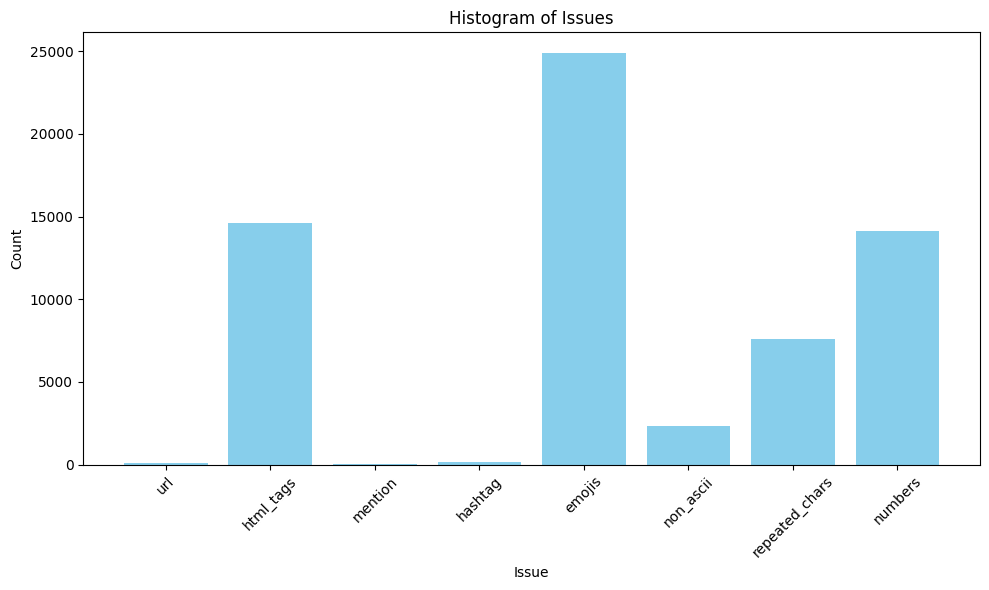

In [20]:
# Membuat histogram
plt.figure(figsize=(10, 6))
plt.bar(df_summary["Issue"], df_summary["Count"], color='skyblue')
plt.title("Histogram of Issues")
plt.xlabel("Issue")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()  # Agar label tidak terpotong
plt.show()

In [21]:
df.drop(columns=["issues"], inplace=True)

In [73]:
df.head(15)

,content,sentiment,clean_content,len_of_x_train
0,"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",0,this was an absolutely terrible movie dont be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudolove affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher walkens good name i could barely sit through it,116.0
1,"I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.",0,i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the sette and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else i cant recommend this film at all,112.0
2,"Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.",0,mann photographs the alberta rocky mountains in a superb fashion and jimmy stewart and walter brennan give enjoyable performances as they always seem to do but come on hollywood a mountie telling the people of dawson city yukon to elect themselves a marshal yes a marshal and to enforce the law themselves then gunfighters battling it out on the streets for control of the town nothing even remotely resembling that happened on the canadian side of the border during the klondike gold rush mr mann and compan

In [23]:
def remove_emoticons(text):
    # Pattern untuk mendeteksi emoticon
    emoticon_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emoticon wajah
        u"\U0001F300-\U0001F5FF"  # Simbol dan Piktogram
        u"\U0001F680-\U0001F6FF"  # Transportasi dan Simbol
        u"\U0001F1E0-\U0001F1FF"  # Bendera (flag)
        u"\U00002702-\U000027B0"  # Lain-lain
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoticon_pattern.sub(r'', text)

In [24]:
df['content']=df['content'].apply(remove_emoticons)

In [25]:
def preprocessing_text (text) :
    #lowercase ngecilin huruf
    text = text.lower()
    #hapus kalimat yang bukan ASCII
    text = re.sub(r'[^\x00-\x7F]', '', text)
    #hapus format url
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'http\S+|www\S+|https\S+|[a-zA-Z0-9.-]+\.(com|id|net|org|co|info|tv|io|xyz)\S*', '', text, flags=re.MULTILINE)
    text = re.sub(r'http\S+|www\S+|https\S+|[a-zA-Z0-9.-]+\.(com|id|net|org|co|info|tv|io|xyz|twitter\.com|instagram\.com|facebook\.com)\s*\S*', '', text, flags=re.MULTILINE)
    #hapus format tag html
    text = re.sub(r'<.*?>', '', text)
    #hapus tanda baca dan nomor
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    #hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    #menghapus karakter berlebih (misalnya loooove harusnya love), meet
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub("[^A-Za-z\s']"," ", text) #Menghilangkan yang bukan huruf
    text = re.sub("@[A-Za-z0-9_]+"," ", text) #Menghilangkan mention
    text = re.sub("#[A-Za-z0-9_]+"," ", text) #Menghilangkan hashtag
    # text = re.sub("rt", " ", text, flags=re.IGNORECASE) #menghilangkan RT
    text = re.sub(r'(\W)\1+', r'\1', text)  # Menghapus tanda baca yang berulang
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus semua tanda baca



    return text

In [26]:
df['clean_content']=df['content'].apply(preprocessing_text)

In [74]:
df['clean_content'].head(15)

,clean_content
0,this was an absolutely terrible movie dont be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudolove affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher walkens good name i could barely sit through it
1,i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the sette and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else i cant recommend this film at all
2,mann photographs the alberta rocky mountains in a superb fashion and jimmy stewart and walter brennan give enjoyable performances as they always seem to do but come on hollywood a mountie telling the people of dawson city yukon to elect themselves a marshal yes a marshal and to enforce the law themselves then gunfighters battling it out on the streets for control of the town nothing even remotely resembling that happened on the canadian side of the border during the klondike gold rush mr mann and company appear to have mistaken dawson city for deadwood the canadian north for the american wild westcanadian viewers be prepared for a reefer madness type of enjoyable howl with this ludicrous plot or to shake your head in disgust
3,this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big armchair and mellow for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no rapids to cross no dangerous waters just a warm and witty paddle through new york life at its best a family film in every sense and one that deserves the praise it received
4,as others have mentioned all the women that go nude in this film are mostly absolutely gorgeous the plot very ably shows the hypocrisy of the female libido when men are around they want to be pursued but when no men are around they become the pursuers of a year old boy and the boy becomes a man really fast we should all be so lucky at this age he then gets up the courage to pursue his true love
5,this is a film which should be seen by anybody interested in effected by or suffering from an eating disorder it is an amazingly accurate and sensitive portrayal of bulimia in a teenage girl its causes and its symptoms the girl is played by one of the most brilliant young actresses working in cinema today alison lohman who was later so spectacular in where the truth lies i would recommend that this film be shown in all schools as you will never see a better on this subject alison lohman is absolutely outstanding and one marvels at her ability to convey the anguish of a girl suffering from this compulsive disorder if barometers tell us the air pressure alison lohman tells us the emotional pressure with the same degree of accuracy her emotional range is so precise each scene could be measured microscopically for its gradations of trauma on a scale of rising hysteria and desperation which reaches unbearable intensity mare winningham is the perfect choice to play her mother and does so with immense sympathy and a range of emotions just as finely tuned as lohmans together th

In [28]:
df["issues"] = df["clean_content"].apply(detect_issues)
summary = {
    issue: df["issues"].apply(lambda x: x[issue]).sum()
    for issue in ["url", "html_tags", "mention", "hashtag", "emojis", "non_ascii", "repeated_chars", "numbers"]
}
df_summary = pd.DataFrame(summary.items(), columns=["Issue", "Count"])
print("Summary of issues:")
print(pd.DataFrame(summary.items(), columns=["Issue", "Count"]))

Summary of issues:
            Issue  Count
0             url      0
1       html_tags      0
2         mention      0
3         hashtag      0
4          emojis      0
5       non_ascii      0
6  repeated_chars      0
7         numbers      0


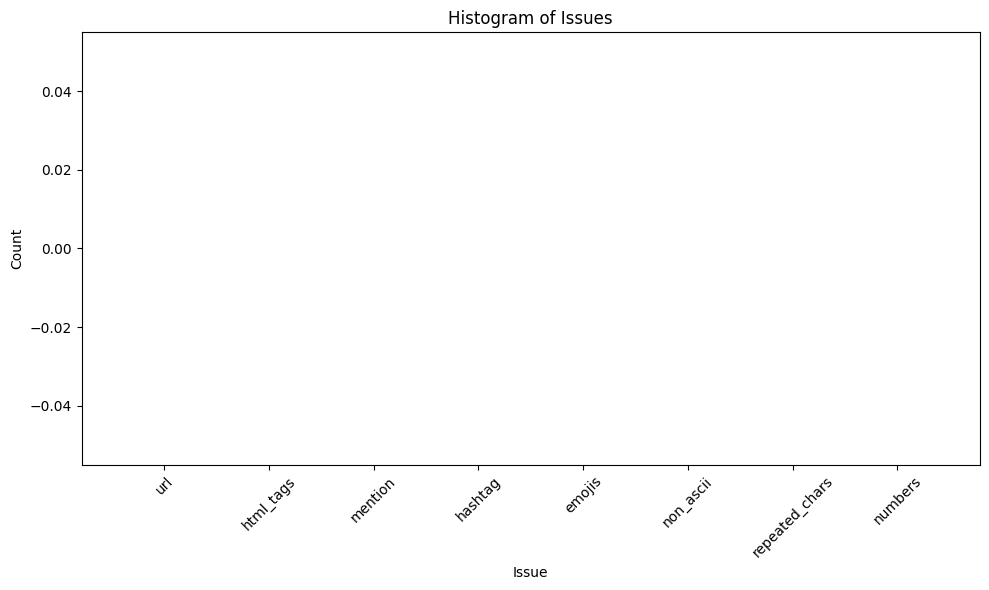

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(df_summary["Issue"], df_summary["Count"], color='skyblue')
plt.title("Histogram of Issues")
plt.xlabel("Issue")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()  # Agar label tidak terpotong
plt.show()

In [30]:
#Tampilkan hasil
df_with_issues = df[df["issues"].apply(lambda x: any(x.values()))]
print(df_with_issues['content'].head(10))

Series([], Name: content, dtype: object)


In [31]:
df.drop(columns=["issues"], inplace=True)

In [32]:
X = df['clean_content']
y = to_categorical(df['sentiment'],num_classes=2)

In [33]:
print(y)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


## FEATURES ENGINEERING ( TOKENISASI DAN WORD EMBEDDING )

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [35]:
print(X_train.shape)
print(y_train.shape)

(22413,)
(22413, 2)


In [36]:
print(X_test.shape)
print(y_test.shape)

(2491,)
(2491, 2)


In [37]:
def count_words(text):
    words = text.split()  # Memecah teks menjadi kata-kata berdasarkan spasi
    return len(words)  # Mengembalikan jumlah kata


In [38]:
df["len_of_x_train"]=X_train.apply(count_words)

In [39]:
df['len_of_x_train'].describe()

,len_of_x_train
count,22413.000000
mean,228.456208
std,170.014886
min,11.000000
25%,124.000000
50%,171.000000
75%,277.000000
max,2441.000000


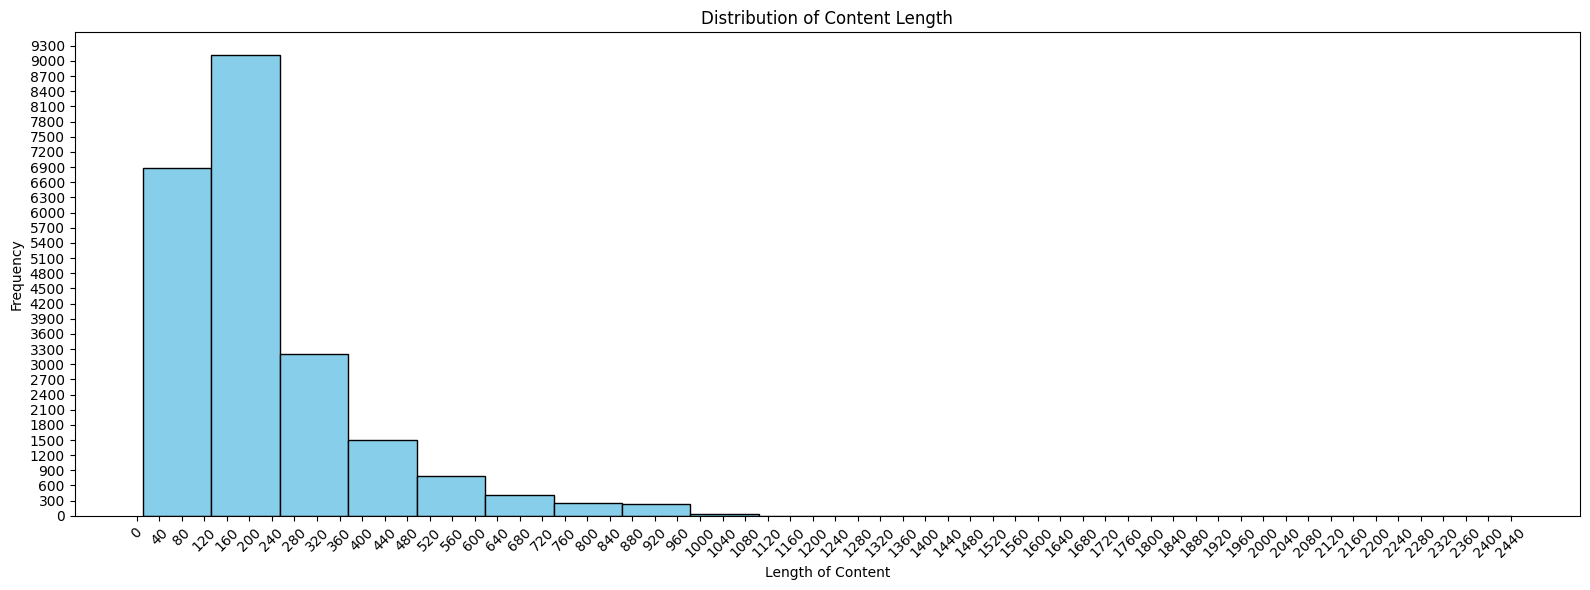

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Data Histogram (gantilah ini dengan data Anda)
data = df['len_of_x_train']

# Membuat histogram
plt.figure(figsize=(16, 6))
plt.hist(data, bins=20, color='skyblue', edgecolor='black')

# Menambahkan judul dan label
plt.title("Distribution of Content Length")
plt.xlabel("Length of Content")
plt.ylabel("Frequency")

# Atur sumbu x dengan interval kelipatan 500
x_ticks = np.arange(0, data.max(), 40)
plt.xticks(x_ticks, rotation=45)

# Atur sumbu y dengan interval kelipatan 500
y_ticks = np.arange(0, plt.gca().get_ylim()[1], 300)  # Mengambil rentang y dan mengaturnya
plt.yticks(y_ticks)

plt.tight_layout()  # Agar elemen tidak terpotong
plt.show()


In [41]:
df["len_of_x_train"].skew()

2.192832682647991

In [42]:
precentile_95 = df['len_of_x_train'].quantile(0.95) # mengambil nilai pada batas atas dari data
adjustment_factor = 0.25 #rentang 0.2 sampai 0.3 cocok untuk skewness > 1 (kemiringan positif extreme)
median_len = df['len_of_x_train'].median() # nilai tengah dari data
test_max_len = median_len + (precentile_95 - median_len) * adjustment_factor # mendapatkan nilai optimum untuk panjang maksimum konten (banyak kata) agar menghemat komputasi
print(test_max_len.astype(int))

274


In [43]:
#tokenizer
tokenizer = Tokenizer(num_words=12000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len=274 #ambil dari perhitungan kombinasi antara presentil 95 dan median
X_train_padded = pad_sequences(X_train_seq,maxlen=max_len,padding='post')
X_test_padded = pad_sequences(X_test_seq,maxlen=max_len,padding='post')

In [44]:
print(X_train_padded.shape)  # Memeriksa dimensi data
print(y_train.shape)  # Memeriksa dimensi label

(22413, 274)
(22413, 2)


In [45]:
print(y_test) #cek y_test

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [46]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2024-12-20 01:11:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-20 01:11:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-20 01:11:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [47]:
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [48]:
embedding_index = {}
embedding_dim = 200
glove_file_path = 'glove.6B.200d.txt'

with open(glove_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embedding_index[word] = vector

In [49]:
print(f"total words in glove : {len(embedding_index)}")

total words in glove : 400000


In [50]:
word_index = tokenizer.word_index
vocab_size = min(12000, len(word_index)+1)
embedding_matrix = np.zeros((vocab_size,embedding_dim))

for word,i in word_index.items():
  if i < vocab_size :
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None :
      embedding_matrix[i] = embedding_vector

#MODELLING

RNN DAN TURUNANNYA-> LSTM,GRU,BiRNN, BiLSTM, BiGRU
silakan dicoba


In [51]:
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
)) #input layer

# HIDDEN LAYER
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(16,return_sequences=False)))
model.add(Dropout(0.2))
#OUTPUT LAYER
model.add(Dense(2,activation='softmax'))

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.build(input_shape=(None,max_len))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 274, 200)          2400000   
                                                                 
 bidirectional (Bidirection  (None, 274, 128)          135680    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 274, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 2)                 6

In [52]:
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train_labels),
    y = y_train_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("class weights: ", class_weights_dict)

class weights:  {0: 1.0023703041144902, 1: 0.997640879551322}


In [53]:
history = model.fit(
    X_train_padded,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    class_weight = class_weights_dict,
    callbacks=[early_stopping,reduce_lr],
    )



Epoch 1/20
281/281 [==============================] - 352s 1s/step - loss: 0.6650 - accuracy: 0.6008 - val_loss: 0.5590 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 2/20
281/281 [==============================] - 348s 1s/step - loss: 0.5771 - accuracy: 0.7009 - val_loss: 0.4979 - val_accuracy: 0.7948 - lr: 0.0010
Epoch 3/20
281/281 [==============================] - 344s 1s/step - loss: 0.4216 - accuracy: 0.8127 - val_loss: 0.3883 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 4/20
281/281 [==============================] - 344s 1s/step - loss: 0.3807 - accuracy: 0.8363 - val_loss: 0.3733 - val_accuracy: 0.8405 - lr: 0.0010
Epoch 5/20
281/281 [==============================] - 321s 1s/step - loss: 0.3494 - accuracy: 0.8524 - val_loss: 0.3387 - val_accuracy: 0.8534 - lr: 0.0010
Epoch 6/20
281/281 [==============================] - 348s 1s/step - loss: 0.3303 - accuracy: 0.8638 - val_loss: 0.3739 - val_accuracy: 0.8479 - lr: 0.0010
Epoch 7/20
281/281 [==============================] - 336s 1s/st

#EVALUASI MODEL

In [54]:
y_pred = model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(classification_report(y_test_labels, y_pred_labels, target_names=['negative', 'positive']))


78/78 [==============================] - 23s 254ms/step
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      1252
    positive       0.88      0.88      0.88      1239

    accuracy                           0.88      2491
   macro avg       0.88      0.88      0.88      2491
weighted avg       0.88      0.88      0.88      2491



In [55]:
score = model.evaluate(X_test_padded,y_test,verbose=1)

78/78 [==============================] - 22s 288ms/step - loss: 0.3319 - accuracy: 0.8800


In [56]:
print("test score :", score[0])
print("test akurasi", score[1])

test score : 0.3318876624107361
test akurasi 0.8799678683280945


<Axes: >

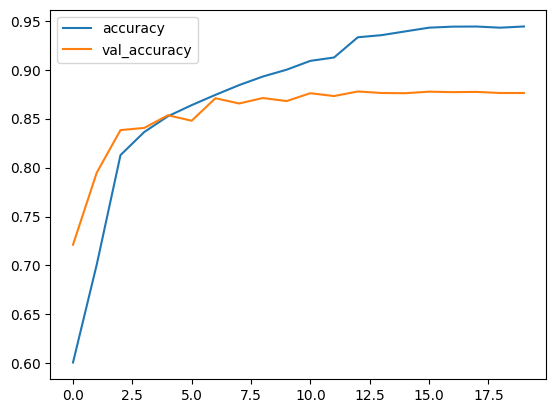

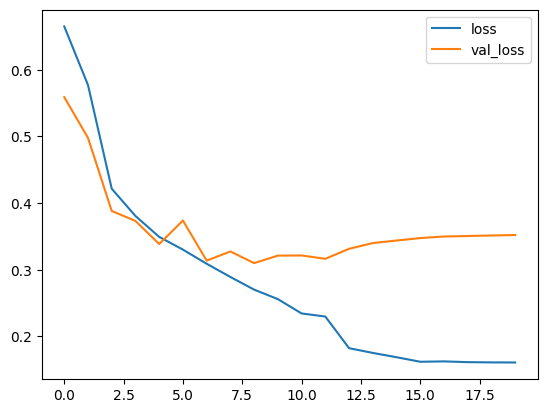

In [57]:
metrics = pd.DataFrame(history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

#SAVE MODELS DALAM H5

In [58]:
model.save('modelmovie5.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
# Simpan tokenizer setelah training
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
from tensorflow.keras.models import load_model


def prepare_input(text):

    # hapus emoticons
    text = remove_emoticons(text)

    # Preprocessing teks baru
    text = preprocessing_text(text)

    # Tokenisasi teks
    text_seq = tokenizer.texts_to_sequences([text])

    # Padding agar panjangnya konsisten
    text_padded = pad_sequences(text_seq, maxlen=max_len, padding='post')
    return text_padded

# Langkah 3: Memuat Model
model = load_model('modelmovie5.h5')  # Ganti dengan path model .h5 Anda

# Langkah 4: Prediksi Sentimen
def predict_sentiment(text):
    with open('tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)

    # Siapkan input teks
    text_input = prepare_input(text)

    # Melakukan prediksi dengan model
    prediction = model.predict(text_input)

    # Menentukan hasil sentimen
    # sentiment = 'Positive' if prediction[0][0] > 0.5 else 'Negative'
    # print(prediction)
    return prediction



In [61]:
# Contoh Penggunaan
sample_comment ="A perfect blend of action, emotion, and humor, this movie had everything I could ask for. The story was engaging, with twists that were both surprising and satisfying. The character development was top-notch, making me care deeply about their journeys. The dialogue felt natural, witty, and heartfelt at the right moments. Visually, it was stunning; the special effects and set designs were flawless. This movie is a shining example of what great filmmaking looks like. I left the theater feeling inspired and uplifted. Absolutely one of the best films of the year!"
sentiment = predict_sentiment(sample_comment)
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 2s 2s/step
Sentiment: [[0.00541673 0.9945833 ]]


In [62]:
# Contoh Penggunaan
sample_comment ="I can’t believe I wasted two hours of my life on this. The storyline was unoriginal and felt like a rehash of countless other bad movies. The performances were flat, and the actors looked like they didn’t even want to be there. The editing was sloppy, and the transitions between scenes felt jarring and rushed. The dialogue was cliché and, at times, laughably bad. Even the visuals couldn’t save it; they were dull and lacked creativity. Overall, this movie lacked soul, direction, and any redeeming qualities. I regret watching it and wouldn’t recommend it to anyone."
sentiment = predict_sentiment(sample_comment)
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 0s 78ms/step
Sentiment: [[0.9958268  0.00417316]]


In [63]:
# Contoh Penggunaan
sample_comment ="Unforgettable movie! I’m definitely watching this again."
sentiment = predict_sentiment(sample_comment)
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 0s 72ms/step
Sentiment: [[0.01800062 0.9819994 ]]


In [64]:
# Contoh Penggunaan
sample_comment ="Big disappointment! Waste of time and effort."
sentiment = predict_sentiment(sample_comment)
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 0s 126ms/step
Sentiment: [[0.9927348  0.00726521]]


In [65]:
# Contoh Penggunaan
sample_comment ="It's evident the actors tried their best, but the emotional depth required for such a story seemed beyond their reach. The lead’s delivery lacked nuance, making pivotal scenes feel flat. While the cinematography was commendable, the editing often disrupted the flow, leaving the audience disconnected. The script had potential, yet it leaned heavily on clichés, making the dialogue predictable. A more experienced cast might have elevated the material, and tighter pacing could’ve enhanced the narrative. It's not entirely bad, but it feels like a missed opportunity for something truly impactful."
sentiment = predict_sentiment(sample_comment)
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 0s 176ms/step
Sentiment: [[0.9167543  0.08324575]]


In [66]:
# Contoh Penggunaan
sample_comment ="<html> WOW! This movie was absolutely amaaazing! 😍😍 The lead actor's performance was nothing short of speeeeectacular, bringing so much looooooveeeee and depth to the role!! ✨✨ Even the supporting cast was 🥰 incredible, and the story kept me hooked from start to finish!! The cinematography…WOW!! Sooooooo stunning. Sure, there were a few minor flaws, but who caresssss when the overall experience is soooo goooood?? 🎥💖 I’d <b>highly recommend</b> this gem to anyone!!! Totally worth the watch!!! 👏👏👏"
sentiment = predict_sentiment(sample_comment)
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 0s 146ms/step
Sentiment: [[0.00575767 0.99424225]]


In [67]:
# Contoh Penggunaan
sample_comment ="this movie was so bad, it not worth it for 10 dollar ticket"
sentiment = predict_sentiment(sample_comment)
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 0s 154ms/step
Sentiment: [[0.99451196 0.00548807]]


In [68]:
# Contoh Penggunaan
sample_comment ="finally i can smiling a long i watched this movie, because mr.carl can be converted to islam an found his a right path in his life"
sentiment = predict_sentiment(sample_comment)
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 0s 150ms/step
Sentiment: [[0.48758256 0.5124174 ]]


In [69]:
# Contoh Penggunaan
sample_comment ="this movie are not recommended as a family movie because there is a sexual scene that unfit for under 18"
sentiment = predict_sentiment(sample_comment)
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 0s 152ms/step
Sentiment: [[0.90880674 0.0911932 ]]


In [70]:
# Contoh Penggunaan
sample_comment ="what an amazing movie, i can feel for the every scene in this movie"
sentiment = predict_sentiment(sample_comment)
print(f"Sentiment: {sentiment}")

1/1 [==============================] - 0s 200ms/step
Sentiment: [[0.01157223 0.9884278 ]]


## CONCLUSION

Model analisis sentimen komentar film di platform IMDb yang dikembangkan menggunakan algoritma Bidirectional LSTM menunjukkan kemampuan yang baik dalam menganalisis sentimen, baik negatif maupun positif. Berdasarkan hasil classification report, model ini memiliki akurasi 88%, recall 87%, dan f1-score 87%, yang menunjukkan bahwa model dapat mengklasifikasikan sentimen dengan seimbang pada kedua kelas.